# Vertical plots: 



In [1]:
# imports from packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
from matplotlib.lines import Line2D  # for legend handle
#import seaborn as sns
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from datetime import datetime

# imports from files
import functions
import read_cdp
import read_cip_txt
#import read_lwc
import read_nav
import read_cip_nc
import plots
import numb_conc
import read_seaice
#import in_cloud_detect
#from data_intake import read_sic
#from plots import plots.letter_annotation
from plots import plot_map

# surpress UserWarning connected to timezoneless np.datetime
warnings.filterwarnings("ignore", message="no explicit representation of timezones available for np.datetime64")
# surpress UserWrning connected to boolean series indexing (creating dataframe with null values)
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index.")

In [2]:
# --- Global formatting/settings/variables



# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# colors for flights (to use all the same colors!)
c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:green',
              'IS22-03':'tab:red',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:blue',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:gray',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:cyan',
              'IS22-10':'tab:pink',
              'IS22-11':'tab:orange'}

# Threshold for in-cloud values
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

In [3]:
# --- Data import
# Based on scripts in files read_*.py

# Navigational data (nav_df: data variables, nav_stats_dict: statistics for each flight)
nav_df, nav_stats_dict, extra_info= read_nav.read_nav() # extra infor includes limits for the plots and extra landing and takeoff times

# CDP data (cdp_bulk_df: Bulk variables per flight, cdp_bins_df: Bin details (max, min size)
#           cdp_var_df: Variable information (names, units), cdp_meta_df: Metadata/instrument settings)
cdp_bulk_df, cdp_bins_df, cdp_var_df, cdp_meta_df = read_cdp.read_cdp(nav_df)

# CIP data 
# nc file(bulk information) (cip_bulk_calc_df: Bulk variables per flight, cip_conc_df: Concentration per bin, 
#                            cip_varnc_df: Variable, longname and unit)
cip_bulk_calc_df, cip_conc_df, cip_varnc_df = read_cip_nc.read_cip_nc() 
cip_pb_df, cip_bins_df, cip_var_df, cip_proc_df = read_cip_txt.read_cip_txt()



----Reading CDP files:
Reading: ../2022-islas/as220014/microphy/pads/20220403071511/02CDP 20220403071511.csv
Reading: ../2022-islas/as220009/microphy/pads/20220326080106/02CDP 20220326080106.csv
Reading: ../2022-islas/as220010/microphy/pads/02CDP 20220326133751.csv
Reading: ../2022-islas/as220007/microphy/pads/20220324080247/02CDP 20220322105458.csv
Reading: ../2022-islas/as220015/microphy/pads/20220403123534/02CDP 20220403123534.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324080247/02CDP 20220324080247.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324113123/02CDP 20220324113123.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324130909/02CDP 20220324130909.csv
Reading: ../2022-islas/as220013/microphy/pads/20220331093304/02CDP 20220331093304.csv
Reading: ../2022-islas/as220011/microphy/pads/02CDP 20220329081432.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330135853/02CDP 20220330135853.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330134834/

In [4]:
# -- Prepare dataframe for calculations
# Join the relevant columns from the nav, the cip, and the cdp data
# CIP IWC, LWC etc have been calculated for particles >100 mum
cip_df = cip_bulk_calc_df[['time', 'NT (#/m3)','IWC (gram/m3)','LWC (gram/m3)', 'MVD (um)']].sort_values(by='time', axis=0)
cdp_df = cdp_bulk_df[['time', 'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)','MVD (um)','Number Conc (#/cm^3)', 'LWC (g/m^3)']].sort_values(by='time', axis=0)

# rename columns to identify instrument and standardize units
cip_df = cip_df.rename(columns={'NT (#/m3)':'cip NumConc (#/m^3)','IWC (gram/m3)':'cip IWC (g/m^3)','LWC (gram/m3)':'cip LWC (g/m^3)', 'MVD (um)':'cip MVD (um)'})
cdp_df = cdp_df.rename(columns={'Number Conc corr (#/cm^3)': 'cdp NumConc corr (#/cm^3)', 'LWC corr (g/m^3)':'cdp LWC corr (g/m^3)',
                                'MVD (um)': 'cdp MVD (um)','Number Conc (#/cm^3)': 'cdp NumConc (#/cm^3)', 'LWC (g/m^3)':'cdp LWC (g/m^3)'})

# select temperature and flightid from nav
nav_sel_df = nav_df[['Latitude (degree)', 'Longitude (degree)','Altitude (meter)','Temperature (Celsius)','TAS (m/s)','flightid', 'safireid']].sort_values(by='time', axis=0)

# join cip and cdp by time
meas_df = pd.merge_asof(cip_df, cdp_df, on = 'time', direction = 'nearest', suffixes=('_cip','_cdp'))
microphy_df = pd.merge_asof(meas_df, nav_sel_df, on = 'time', direction = 'nearest')

# add manually set selection categories
microphy_df = functions.add_man_relevance(microphy_df) # relevant clouds: lower mixed phase
microphy_df = functions.add_man_cloud(microphy_df)     # cloudid: individual flight patterns from single flights

# prepare dataframe for later calculation of position in cloud and surface conditions:
microphy_df['Cloud_pos']=np.nan # empty column to be filled with cloud positions
microphy_df['Cloud_rel_alt']=np.nan # empty column to be filled with cloud relative altitude (0 = base 1 = top)
microphy_df['surface_cond']='sea-ocean' # set default to sea-ocean

# rearrange columns more logically: - Positional - Identifier - Ambient - Microphysical - Calculated
microphy_df = microphy_df[['time','Latitude (degree)','Longitude (degree)','Altitude (meter)',
                          'flightid', 'safireid',
                          'Temperature (Celsius)','TAS (m/s)',
                           'cip NumConc (#/m^3)','cdp NumConc (#/cm^3)','cdp NumConc corr (#/cm^3)',
                           'cip IWC (g/m^3)','cip LWC (g/m^3)','cdp LWC (g/m^3)','cdp LWC corr (g/m^3)',
                           'cip MVD (um)','cdp MVD (um)',
                           'Relevance','cloudid','Cloud_pos', 'Cloud_rel_alt', 'surface_cond']]


In [5]:
# -- Get sea_ice concentration along flight tracks from satellite data
# Sea ice concentration
seaice_df = read_seaice.read_seaice(microphy_df, extra_info)

# merge with microphy
microphy_df = pd.merge(microphy_df, seaice_df, on=['time','Latitude (degree)','Longitude (degree)','flightid'], how='inner')

# update surface_cond to 'sea-ice' if 'Sea Ice Conc. (Percent)' > 15 %
microphy_df.loc[microphy_df["Sea Ice Conc. (Percent)"] >15, "surface_cond"] = 'sea-ice'

----Reading sea-ice files
Flight: IS22-02, date: 20220322
Flight: IS22-03, date: 20220324
Flight: IS22-04, date: 20220324
Flight: IS22-05, date: 20220326
Flight: IS22-06, date: 20220326
Flight: IS22-07, date: 20220329
Flight: IS22-08, date: 20220330
Flight: IS22-09, date: 20220331
Flight: IS22-10, date: 20220403
Flight: IS22-11, date: 20220403


In [6]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'Sea Ice Conc. (Percent)'],
      dtype='object')

In [7]:
# -- Update surface_cond with land mask

def update_land(row):
    # Function to use globe_land_mask to check each lat, lon pair if land.
    # Returns the original value of 'surface_cond' if not land and 'land' if land

    # import package
    from global_land_mask import globe
    
    if globe.is_land(row['Latitude (degree)'], row['Longitude (degree)']):
        return 'land'
    return row['surface_cond']

# Apply the function to each row
microphy_df['surface_cond'] = microphy_df.apply(update_land, axis=1)

In [8]:
# --- Preparations for binned information (size distributions)

# Add islasids to the binned dataframes
cip_pb_df = functions.safireid_to_islasid(cip_pb_df, extra_info['ext_landing'])
cdp_bulk_df = functions.safireid_to_islasid(cdp_bulk_df, extra_info['ext_landing'])

In [9]:
# --- calculated parameters

# Total number concentration (adding CIP and CDP)
microphy_df['cip NumConc (#/cm^3)'] = microphy_df['cip NumConc (#/m^3)']*10**(-6) # adjust cip to equal units as cdp
# sum cip and cdp in #/cm3 to find total num conc
microphy_df['tot NumConc (#/cm3)'] = microphy_df['cip NumConc (#/cm^3)']+microphy_df['cdp NumConc corr (#/cm^3)']

# TWC - Total Water Content: estimate total water content from cdp LWC and CIP IWC 
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)'] + microphy_df['cip IWC (g/m^3)']

# Selection of in-cloud values (True or False based on threshold condition)
in_cl_th = 0.01 # in-cloud threshold based on Korolev 2003
microphy_df['incloud']= microphy_df['TWC (gram/m3)']>in_cl_th #direct boolean indexing (True if bigger, False if smaller)

# -- incloud height calculations
# calculating in-cloud altitude dictionary for all named clouds:
cloud_alt_dict = functions.cloud_alt_pos(microphy_df, 'cloudid') # get the cloud top and base heights (in a dict)

# Calculating in-cloud relative altitude based on max and min altitude of cloud
cloudids = microphy_df[microphy_df['cloudid']!='nan']['cloudid'].unique() # get unique cloudids
microphy_df['Cloud_rel_alt']=microphy_df.apply(functions.rel_alt, args=(cloudids, cloud_alt_dict), axis=1)

# set category "Top-Bulk-Base", categorize data based on where in cloud:
# Apply the function row-wise to create the new column
microphy_df['Cloud_pos'] = microphy_df.apply(functions.set_c_pos_cat, cloud_pos_dict = cloud_alt_dict, axis=1)

## Issues with preparing for making the number concentation plots that needs to be adressed:
Want to: add surface information and where in cloud information to the two binned dfs. 

### differences in timesteps between datasets
- Microphy_df: 5 s
- cip_pb_df: 5 s 
- cip_bulk_df: 1 s 

### Data issues (TODO/CHECK)
- Check why no cip_pd_df data from IS22-04, cip_df has IS22-04 data:
  
cip_pb_df[(cip_pb_df['time']<'2022-03-25')&(cip_pb_df['time']>'2022-03-23')] only IS22-03 data
cip_df[(cip_df['time']<'2022-03-25')&(cip_df['time']>'2022-03-23')] gives also IS22-04 data

In [10]:
# --- adding categorizing columns to the dfs needed for size distribution calculations
# ---- Testing: full dataset

# Find the columns from microphy you wish to join with cip_pb_df & cdp_bulk_df:
# columns to add: 'surface_cond', 'cloudid', 'Cloud_pos'
# joint columns: 'time' (alt.'flightid', 'safireid')
# microphy_df.columns # to see all columns

# need to sort the dfs on time before joining
cip_pb_df = cip_pb_df.sort_values(by='time')
cdp_bulk_df = cdp_bulk_df.sort_values(by='time')

# Join certain colums from microphy to cdp_pb on time
# TODO: double check how the cdp is combined!! microphy_df is in 5 sek intervals, cdp_bulk_df is in 1 sk intervals. 
# Be sure of what nearest means in this context.

cip_pb_df = pd.merge_asof(cip_pb_df, microphy_df[['time','surface_cond', 'cloudid','Cloud_pos', 'incloud','Relevance']], on = 'time', direction = 'nearest')
cdp_bulk_df = pd.merge_asof(cdp_bulk_df, microphy_df[['time','surface_cond', 'cloudid','Cloud_pos', 'incloud','Relevance']], on = 'time', direction = 'nearest')

cip_pb_df.head()

,UTC Seconds,Nt,IWC,MMD,Conc001,Conc002,Conc003,Conc004,Conc005,Conc006,...,Conc063,Conc064,safireid,time,flightid,surface_cond,cloudid,Cloud_pos,incloud,Relevance
0,41841.0,1180.0,0.001790,199.0,208000000.0,21100000.0,0.0,10900000.0,7120000.0,12600000.0,...,0.0,0.0,as220007,2022-03-22 11:37:21,IS22-02,land,nan,None,False,Upper clouds
1,41846.0,455.0,0.000519,169.0,162000000.0,16400000.0,7430000.0,8500000.0,12400000.0,977000.0,...,0.0,0.0,as220007,2022-03-22 11:37:26,IS22-02,land,nan,None,False,Upper clouds
2,41851.0,674.0,0.001100,213.0,0.0,0.0,0.0,6430000.0,6980000.0,4930000.0,...,0.0,0.0,as220007,2022-03-22 11:37:31,IS22-02,land,nan,None,False,Upper clouds
3,41856.0,531.0,0.000675,193.0,0.0,0.0,4620000.0,2640000.0,8600000.0,2430000.0,...,0.0,0.0,as220007,2022-03-22 11:37:36,IS22-02,land,nan,None,False,Upper clouds
4,41861.0,722.0,0.001080,208.0,97000000.0,8220000.0,3710000.0,2120000.0,11100000.0,977000.0,...,0.0,0.0,as220007,2022-03-22 11:37:41,IS22-02,land,nan,None,False,Upper clouds


In [11]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'Sea Ice Conc. (Percent)', 'cip NumConc (#/cm^3)',
       'tot NumConc (#/cm3)', 'TWC (gram/m3)', 'incloud'],
      dtype='object')

In [12]:
# -- Calculate SLF (supercooled liquid fraction)
# estimate total water content from cdp as liquid and all from CIP as ice (use LWC from cdp and IWC from CIP)
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)']+microphy_df['cip IWC (g/m^3)']

# masking all values of TWC lower than in cloud threshold
microphy_df['TWC (gram/m3)'] = microphy_df['TWC (gram/m3)'].mask(microphy_df['TWC (gram/m3)'] < lwc_th)

# also mask cloud parameters for same time step
microphy_df['cdp LWC corr (g/m^3)'] = microphy_df['cdp LWC corr (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['cip IWC (g/m^3)'] = microphy_df['cip IWC (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['tot NumConc (#/cm3)'] = microphy_df['tot NumConc (#/cm3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))

# calculate SLF by dividing LWC with TWC
microphy_df['SLF']= microphy_df['cdp LWC corr (g/m^3)']/microphy_df['TWC (gram/m3)']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"Outside of cloud")

In [13]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'Sea Ice Conc. (Percent)', 'cip NumConc (#/cm^3)',
       'tot NumConc (#/cm3)', 'TWC (gram/m3)', 'incloud', 'SLF',
       'cloud_phase'],
      dtype='object')

In [14]:
# Getting overall values of number concentration in-cloud for relevant clouds

# select only in-cloud values:
incloud_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['Relevance']=='Lower clouds, relevant')]
incloud_ocean_df = incloud_df[incloud_df['surface_cond']=='sea-ocean']
incloud_ice_df = incloud_df[incloud_df['surface_cond']=='sea-ice']

# mean and max total number concentration for all ISLAS clouds, clouds over ocean, clouds over ice
TNC_all_max = max(incloud_df['tot NumConc (#/cm3)'])
TNC_all_mean = np.mean(incloud_df['tot NumConc (#/cm3)'])
TNC_ocean_max = max(incloud_ocean_df['tot NumConc (#/cm3)'])
TNC_ocean_mean = np.mean(incloud_ocean_df['tot NumConc (#/cm3)'])
TNC_ice_max = max(incloud_ice_df['tot NumConc (#/cm3)'])
TNC_ice_mean = np.mean(incloud_ice_df['tot NumConc (#/cm3)'])

# Print out info
print(f'Total number concentration (CDP + CIP)')
print(f'All in-cloud values({len(incloud_df)} values): ')
print(f'max tot NumConc (#/cm3): {TNC_all_max} ')
print(f'mean tot NumConc (#/cm3): {TNC_all_mean} ')
print('---')
print(f'In-cloud values over open ocean({len(incloud_ocean_df)} values): ')
print(f'max tot NumConc (#/cm3): {TNC_ocean_max} ')
print(f'mean tot NumConc (#/cm3): {TNC_ocean_mean} ')
print('---')
print(f'In-cloud values over sea-ice({len(incloud_ice_df)} values): ')
print(f'max tot NumConc (#/cm3): {TNC_ice_max} ')
print(f'mean tot NumConc (#/cm3): {TNC_ice_mean}')

Total number concentration (CDP + CIP)
All in-cloud values(5249 values): 
max tot NumConc (#/cm3): 603.1809213563959 
mean tot NumConc (#/cm3): 21.476893299663008 
---
In-cloud values over open ocean(4830 values): 
max tot NumConc (#/cm3): 603.1809213563959 
mean tot NumConc (#/cm3): 22.084769802605557 
---
In-cloud values over sea-ice(356 values): 
max tot NumConc (#/cm3): 321.17911778996626 
mean tot NumConc (#/cm3): 10.426864469165464


In [15]:
incloud_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'Sea Ice Conc. (Percent)', 'cip NumConc (#/cm^3)',
       'tot NumConc (#/cm3)', 'TWC (gram/m3)', 'incloud', 'SLF',
       'cloud_phase'],
      dtype='object')

In [16]:
# --- interesting values per cloudid (grouped by 'cloudid')

# Number concentration
cloud_TotNumbConc = incloud_df.groupby('cloudid').agg({'tot NumConc (#/cm3)': ['mean', 'std', 'max']})
cloud_IceNumbConc = incloud_df.groupby('cloudid').agg({'cip NumConc (#/cm^3)': ['mean', 'std', 'max']})
cloud_DropNumbConc = incloud_df.groupby('cloudid').agg({'cdp NumConc corr (#/cm^3)': ['mean', 'std', 'max']})

# Water content
cloud_TWC = incloud_df.groupby('cloudid').agg({'TWC (gram/m3)': ['mean', 'std', 'max']})
cloud_IWC = incloud_df.groupby('cloudid').agg({'cip IWC (g/m^3)': ['mean', 'std', 'max']})
cloud_LWC = incloud_df.groupby('cloudid').agg({'cdp LWC corr (g/m^3)': ['mean', 'std', 'max']})

# Temperature and altitude
cloud_temps = incloud_df.groupby('cloudid').agg({'Temperature (Celsius)': ['mean', 'min', 'max']})
cloud_alts = incloud_df.groupby('cloudid').agg({'Altitude (meter)': ['mean', 'min', 'max']})

print(cloud_TotNumbConc)

          tot NumConc (#/cm3)                        
                         mean         std         max
cloudid                                              
IS22-02-a            1.916720    7.554032   75.927271
IS22-02-b           24.170425   28.445208   82.291792
IS22-03-a           32.827318   50.680593  242.701835
IS22-04-a           25.324642   46.001456  236.264639
IS22-05-a           16.764247   55.255744  279.468976
IS22-05-b           45.523178   72.836482  275.673422
IS22-05-c           22.814327   47.671936  197.174383
IS22-06-a           15.484593   21.660159   82.431325
IS22-06-b            7.624373   17.602517   85.523971
IS22-06-c           28.896367   32.110858   96.883651
IS22-07-a           48.383474   50.519705  189.109348
IS22-07-b           20.530401   27.336028  101.548869
IS22-07-c           22.673741   36.339685  151.893005
IS22-08-a           10.259258   21.678297  101.787819
IS22-08-b           16.369159   23.045533   83.724776
IS22-09-a           37.89837

In [17]:
# create categorical altitude variable based on altitude values
# for boxplots etc.

bins = np.arange(0,2100,300) # altitude bins to generate statistics

# creating altitude categories, (interval and midpoint)
microphy_df['alt_cat'] = pd.cut(microphy_df['Altitude (meter)'], bins=bins)
microphy_df['alt_cat_mid'] = microphy_df['alt_cat'].apply(lambda x: int(x.mid))

In [18]:
# --- selecting case study flight or cloudid

# flight = 'IS22-09' # selecting single flight
# case_df = microphy_df[microphy_df['flightid']==flight]

# interresting clouds to test vertical plots on is:
# IS22-07-a: spiralling up and down flight from the case interresting for Britta etc
# IS22-11-b: porpoising through cloudlayer before crossing over sea-ice
#cloudid = 'IS22-07-a'
#cloudid = 'IS22-11-b'

#case_df = microphy_df[microphy_df['cloudid'] == cloudid]

# selecting on surface
#cond= 'sea-ocean'
cond='sea-ice'
case_df = microphy_df[(microphy_df['surface_cond'] == cond) & (microphy_df['flightid'].isin(['IS22-10','IS22-11'])) & (microphy_df['incloud'] == True)]
case_df['flightid'].unique()

array(['IS22-10', 'IS22-11'], dtype=object)

## Plots


In [19]:

case_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'Sea Ice Conc. (Percent)', 'cip NumConc (#/cm^3)',
       'tot NumConc (#/cm3)', 'TWC (gram/m3)', 'incloud', 'SLF', 'cloud_phase',
       'alt_cat', 'alt_cat_mid'],
      dtype='object')

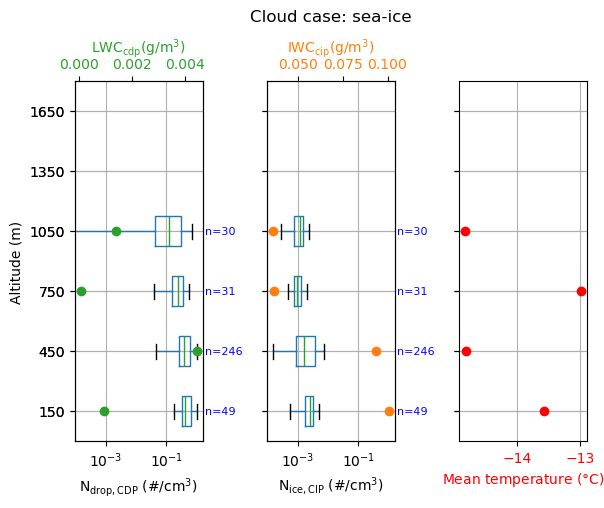

In [20]:
# -- recreating figure 6 from Young

obs_counts_cdp = case_df.groupby('alt_cat_mid', observed=True)['cdp NumConc corr (#/cm^3)'].count()
obs_counts_cip = case_df.groupby('alt_cat_mid', observed=True)['cip NumConc (#/cm^3)'].count()

# Create a figure and axis
fig = plt.figure()
gs = fig.add_gridspec(1, 3, wspace=0.5)
#(ax1,ax2,ax3) = gs.subplots(sharey=True, sharex=True)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharex=ax1, sharey=ax1)
ax3 = plt.subplot(gs[0,2], sharey=ax1)

# add twinaxes to plot multiple parameters in same plot
ax1_t = ax1.twiny()
ax2_t = ax2.twiny()
#ax3_t = ax3.twiny()

# Create a boxplot for the desired column (add ", showfliers=False" to remove outliers)
case_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'alt_cat_mid', ax=ax1, vert=False, showfliers=False)
case_df.boxplot(column='cip NumConc (#/cm^3)', by= 'alt_cat_mid', ax=ax2, vert=False, showfliers=False)

# Annotate the boxplots with the number of observations
for i, (cat, count) in enumerate(obs_counts_cdp.items()):
    if count>0:
        ax1.text(1.9, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# Annotate the boxplots with the number of observations
for i, (cat, count) in enumerate(obs_counts_cip.items()):
    if count>0:
        ax2.text(1.9, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# Calculate the mean temperature for each 'alt_cat'
mean_temps = case_df.groupby('alt_cat_mid', observed = True)['Temperature (Celsius)'].mean()
mean_LWC = case_df.groupby('alt_cat_mid', observed = True)['cdp LWC corr (g/m^3)'].mean()
mean_IWC = case_df.groupby('alt_cat_mid', observed = True)['cip IWC (g/m^3)'].mean()

# Plot the mean temperature in ax3 plot
# When 100 uses this: adj = np.where(bins == (case_df['alt_cat_mid'].min()-50))[0][0] # the startpoint needs to be adjusted to fit the list-based y-axis (yaxis decided by the bins variable)

for i, (cat, mean_temp) in enumerate(mean_temps.items()):
    # when 100 use this: ax3_t.plot(mean_temp, i + adj + 1, 'ro', linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
    ax3.plot(mean_temp, i + 1, 'ro', linewidth = 2)

color = 'tab:green'
ax1_t.set_xlabel('$\mathregular{LWC_{cdp} (g/m^3)}$', color = color) 
for i, (cat, mean_LWC) in enumerate(mean_LWC.items()):
    ax1_t.plot(mean_LWC, i +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
    #ax1_t.plot(mean_LWC, i + adj +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
ax1_t.tick_params(axis ='x', labelcolor = color)

color = 'tab:orange'
ax2_t.set_xlabel('$\mathregular{IWC_{cip} (g/m^3)}$', color = color) 
for i, (cat, mean_IWC) in enumerate(mean_IWC.items()):
    ax2_t.plot(mean_IWC, i + 1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
    #ax2_t.plot(mean_IWC, i + adj +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else ""
ax2_t.tick_params(axis ='x', labelcolor = color)


plt.suptitle(f'Cloud case: {cond}', y=1.05) 


# Set labels and title
ax1.set_xlabel('$\mathregular{N_{drop, CDP}}$ (#/$\mathregular{cm^3}$)')
ax1.set_title('')
ax1.set_xscale('log')
ax1.set_ylabel('Altitude (m)')


ax2.set_xlabel('$\mathregular{N_{ice, CIP}}$ (#/$\mathregular{cm^3}$)')
ax2.set_xscale('log')
ax2.set_title('')

ax3.grid()
ax3.set_xlabel('Mean temperature ($\mathregular{\degree C}$)', c='r')
ax3.tick_params(axis ='x', labelcolor = 'r')
ax3.set_title('')

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(f'numbconc_WC_{cond}.png', bbox_inches='tight')
# Show the plot
plt.show()

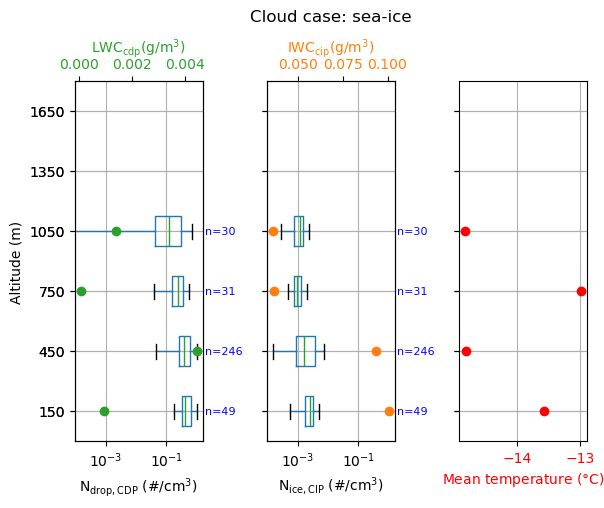

In [20]:
# -- recreating figure 6 from Young

obs_counts_cdp = case_df.groupby('alt_cat_mid', observed=True)['cdp NumConc corr (#/cm^3)'].count()
obs_counts_cip = case_df.groupby('alt_cat_mid', observed=True)['cip NumConc (#/cm^3)'].count()

# Create a figure and axis
fig = plt.figure()
gs = fig.add_gridspec(1, 3, wspace=0.5)
#(ax1,ax2,ax3) = gs.subplots(sharey=True, sharex=True)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharex=ax1, sharey=ax1)
ax3 = plt.subplot(gs[0,2], sharey=ax1)

# add twinaxes to plot multiple parameters in same plot
ax1_t = ax1.twiny()
ax2_t = ax2.twiny()
#ax3_t = ax3.twiny()

# Create a boxplot for the desired column (add ", showfliers=False" to remove outliers)
case_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'alt_cat_mid', ax=ax1, vert=False, showfliers=False)
case_df.boxplot(column='cip NumConc (#/cm^3)', by= 'alt_cat_mid', ax=ax2, vert=False, showfliers=False)

# Annotate the boxplots with the number of observations
for i, (cat, count) in enumerate(obs_counts_cdp.items()):
    if count>0:
        ax1.text(1.9, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# Annotate the boxplots with the number of observations
for i, (cat, count) in enumerate(obs_counts_cip.items()):
    if count>0:
        ax2.text(1.9, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# Calculate the mean temperature for each 'alt_cat'
mean_temps = case_df.groupby('alt_cat_mid', observed = True)['Temperature (Celsius)'].mean()
mean_LWC = case_df.groupby('alt_cat_mid', observed = True)['cdp LWC corr (g/m^3)'].mean()
mean_IWC = case_df.groupby('alt_cat_mid', observed = True)['cip IWC (g/m^3)'].mean()

# Plot the mean temperature in ax3 plot
# When 100 uses this: adj = np.where(bins == (case_df['alt_cat_mid'].min()-50))[0][0] # the startpoint needs to be adjusted to fit the list-based y-axis (yaxis decided by the bins variable)

for i, (cat, mean_temp) in enumerate(mean_temps.items()):
    # when 100 use this: ax3_t.plot(mean_temp, i + adj + 1, 'ro', linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
    ax3.plot(mean_temp, i + 1, 'ro', linewidth = 2)

color = 'tab:green'
ax1_t.set_xlabel('$\mathregular{LWC_{cdp} (g/m^3)}$', color = color) 
for i, (cat, mean_LWC) in enumerate(mean_LWC.items()):
    ax1_t.plot(mean_LWC, i +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
    #ax1_t.plot(mean_LWC, i + adj +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
ax1_t.tick_params(axis ='x', labelcolor = color)

color = 'tab:orange'
ax2_t.set_xlabel('$\mathregular{IWC_{cip} (g/m^3)}$', color = color) 
for i, (cat, mean_IWC) in enumerate(mean_IWC.items()):
    ax2_t.plot(mean_IWC, i + 1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
    #ax2_t.plot(mean_IWC, i + adj +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else ""
ax2_t.tick_params(axis ='x', labelcolor = color)


plt.suptitle(f'Cloud case: {cond}', y=1.05) 


# Set labels and title
ax1.set_xlabel('$\mathregular{N_{drop, CDP}}$ (#/$\mathregular{cm^3}$)')
ax1.set_title('')
ax1.set_xscale('log')
ax1.set_ylabel('Altitude (m)')


ax2.set_xlabel('$\mathregular{N_{ice, CIP}}$ (#/$\mathregular{cm^3}$)')
ax2.set_xscale('log')
ax2.set_title('')

ax3.grid()
ax3.set_xlabel('Mean temperature ($\mathregular{\degree C}$)', c='r')
ax3.tick_params(axis ='x', labelcolor = 'r')
ax3.set_title('')

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(f'numbconc_WC_{cond}.png', bbox_inches='tight')
# Show the plot
plt.show()

In [145]:
case_df[(case_df['alt_cat_mid']==150) & (case_df['cip NumConc (#/cm^3)']>0)]


,time,Latitude (degree),Longitude (degree),Altitude (meter),flightid,safireid,Temperature (Celsius),TAS (m/s),cip NumConc (#/m^3),cdp NumConc (#/cm^3),...,surface_cond,Sea Ice Conc. (Percent),cip NumConc (#/cm^3),tot NumConc (#/cm3),TWC (gram/m3),incloud,SLF,cloud_phase,alt_cat,alt_cat_mid
24859,2022-04-03 14:18:54,75.503464,16.002483,298.566833,IS22-11,as220015,-12.209013,101.824837,2038.099976,0.223048,...,sea-ocean,0.000000,0.002038,0.253820,0.043842,True,6.320978,liquid,"(0, 300]",150
24860,2022-04-03 14:18:59,75.501793,16.017859,298.325073,IS22-11,as220015,-12.085465,98.882523,1821.645630,0.446097,...,sea-ocean,0.000000,0.001822,0.520372,0.042909,True,4.914121,liquid,"(0, 300]",150
24862,2022-04-03 14:19:09,75.500137,16.049212,290.498901,IS22-11,as220015,-12.317063,98.519760,2648.134766,0.371747,...,sea-ocean,0.000000,0.002648,0.436364,0.084476,True,0.534485,mixed-phase,"(0, 300]",150
24863,2022-04-03 14:19:14,75.499733,16.064901,284.477753,IS22-11,as220015,-11.816665,96.222382,1131.173218,0.371747,...,sea-ocean,0.000000,0.001131,0.445202,0.013740,True,0.947658,liquid,"(0, 300]",150
24864,2022-04-03 14:19:19,75.499603,16.080357,296.736206,IS22-11,as220015,-12.340890,97.072556,3627.941650,0.185874,...,sea-ocean,0.000000,0.003628,0.223719,0.081574,True,0.095834,ice,"(0, 300]",150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25012,2022-04-03 14:31:39,75.513138,18.190634,296.371185,IS22-11,as220015,-13.349391,90.402832,1321.220459,0.446097,...,sea-ocean,14.704687,0.001321,0.568510,0.013666,True,0.204322,mixed-phase,"(0, 300]",150
25013,2022-04-03 14:31:44,75.513153,18.204803,294.743805,IS22-11,as220015,-13.258532,91.511650,1698.606201,0.111524,...,sea-ocean,14.704687,0.001699,0.141777,0.017686,True,0.031086,ice,"(0, 300]",150
25014,2022-04-03 14:31:49,75.513161,18.218998,295.023346,IS22-11,as220015,-13.397608,90.848984,1331.072266,0.148699,...,sea-ocean,14.704687,0.001331,0.189466,0.019064,True,0.064526,ice,"(0, 300]",150
25015,2022-04-03 14:31:54,75.513176,18.233187,294.924988,IS22-11,as220015,-13.351457,91.256157,1606.923828,0.297398,...,sea-ocean,14.704687,0.001607,0.376197,0.029664,True,0.054962,ice,"(0, 300]",150


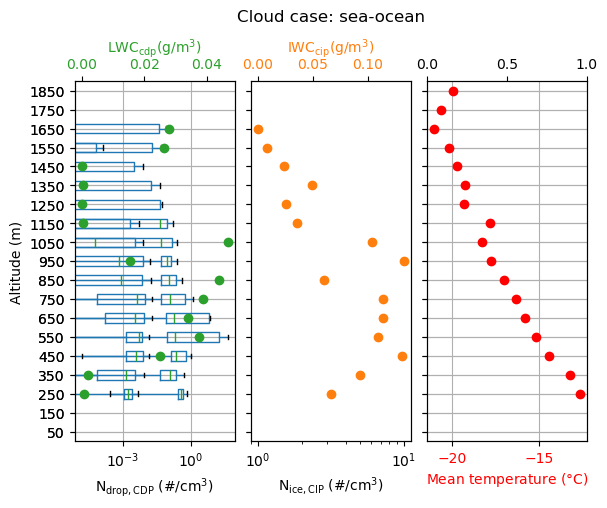

In [62]:
# -- recreating figure 6 from Young

# Create means per altitude level for LWC, IWC and temperature
case_alt_means = case_df.groupby(case_df['alt_cat_mid'], observed=True).agg({'Temperature (Celsius)': ['mean'],
                                                                                            'cdp LWC (g/m^3)': ['mean'],
                                                                                            'cip IWC (g/m^3)': ['mean']}).reset_index()


# Create a figure and axis
fig = plt.figure()
gs = fig.add_gridspec(1, 3, wspace=0.1)
(ax1,ax2,ax3) = gs.subplots(sharey=True)

# add twinaxes to plot multiple parameters in same plot
ax1_t = ax1.twiny()
ax2_t = ax2.twiny()
ax3_t = ax3.twiny()

# Create a boxplot for the desired column (add ", showfliers=False" to remove outliers)
case_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'alt_cat_mid', ax=ax1, vert=False, showfliers=False,
               label='$\mathregular{N_{drop, CDP}}$')
case_df.boxplot(column='cip NumConc (#/cm^3)', by= 'alt_cat_mid', ax=ax1, vert=False, showfliers=False,
               label = '$\mathregular{IWC_{cip}')

# Calculate the mean temperature for each 'alt_cat'
mean_temps = case_df.groupby('alt_cat_mid', observed = True)['Temperature (Celsius)'].mean()
mean_LWC = case_df.groupby('alt_cat_mid', observed = True)['cdp LWC corr (g/m^3)'].mean()
mean_IWC = case_df.groupby('alt_cat_mid', observed = True)['cip IWC (g/m^3)'].mean()

# Plot the mean temperature in ax3 plot
adj = np.where(bins == (case_df['alt_cat_mid'].min()-50))[0][0] # the startpoint needs to be adjusted to fit the list-based y-axis (yaxis decided by the bins variable)

for i, (cat, mean_temp) in enumerate(mean_temps.items()):
    ax3.plot(mean_temp, i + adj + 1, 'ro', linewidth = 2)#, label='Mean Temperature' if i == 0 else "")


color = 'tab:green'
ax1_t.set_xlabel('$\mathregular{LWC_{cdp} (g/m^3)}$', color = color) 
for i, (cat, mean_LWC) in enumerate(mean_LWC.items()):
    ax1_t.plot(mean_LWC, i + adj +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
ax1_t.tick_params(axis ='x', labelcolor = color)

color = 'tab:orange'
ax2_t.set_xlabel('$\mathregular{IWC_{cip} (g/m^3)}$', color = color) 
for i, (cat, mean_IWC) in enumerate(mean_IWC.items()):
    ax2_t.plot(mean_IWC, i + adj +  1, c = color, ls='-', marker='o',linewidth = 2)#, label='Mean Temperature' if i == 0 else "")
ax2_t.tick_params(axis ='x', labelcolor = color)


plt.suptitle(f'Cloud case: {cond}', y=1.05) 


# Set labels and title
ax1.set_xlabel('$\mathregular{N_{drop, CDP}}$ (#/$\mathregular{cm^3}$)')
ax1.set_title('')
ax1.set_xscale('log')
ax1.set_ylabel('Altitude (m)')

ax2.set_xlabel('$\mathregular{N_{ice, CIP}}$ (#/$\mathregular{cm^3}$)')
ax2.set_xscale('log')
ax2.set_title('')

ax3.grid()
ax3.set_xlabel('Mean temperature ($\mathregular{\degree C}$)', c='r')
ax3.tick_params(axis ='x', labelcolor = 'r')
ax3.set_title('')

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(f'numbconc_WC_{cond}.png', bbox_inches='tight')
# Show the plot
plt.show()

In [187]:
plt.savefig(f'numbconc_WC_{cloudid}.png')

<Figure size 640x480 with 0 Axes>

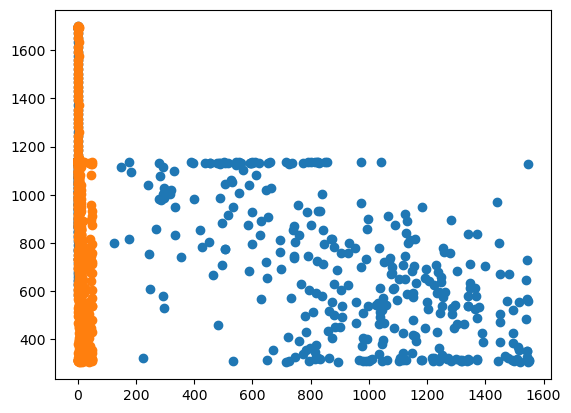

In [185]:
# plot mvd for cip and cdp

fig, ax = plt.subplots()

plt.scatter(case_df['cip MVD (um)'],case_df['Altitude (meter)'])
plt.scatter(case_df['cdp MVD (um)'],case_df['Altitude (meter)'])
plt.show()


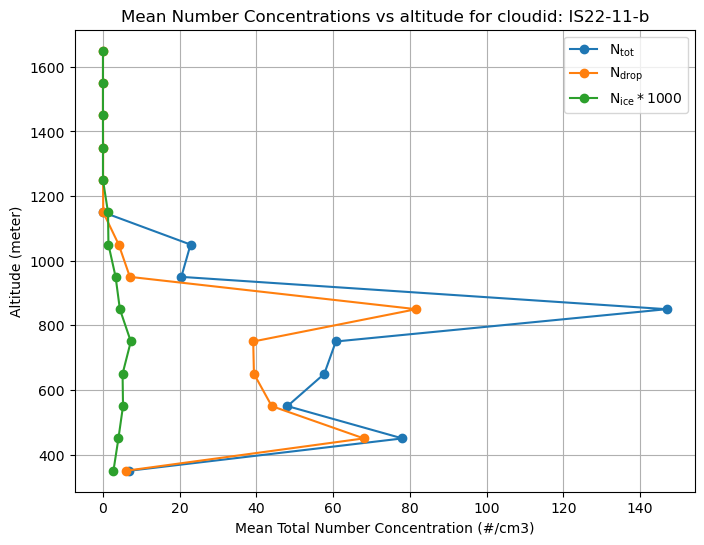

   alt_cat_mid tot NumConc (#/cm3) cdp NumConc corr (#/cm^3)  \
                              mean                      mean   
0          350            6.913983                  6.050498   
1          450           78.030703                 67.971302   
2          550           48.077155                 43.981280   
3          650           57.675913                 39.339775   
4          750           60.685307                 39.154147   
5          850          146.872309                 81.630118   
6          950           20.423609                  7.015958   
7         1050           22.820165                  4.105692   
8         1150            0.070091                  0.066278   
9         1250                 NaN                  0.028777   
10        1350                 NaN                  0.043614   
11        1450                 NaN                  0.000000   
12        1550                 NaN                  0.006771   
13        1650                 NaN      

In [60]:
# -- Recreating Fig. 2 from Ehrlich 2008
# - first part of plot:
# -- number concentration : 'cdp NumConc corr (#/cm^3)', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)'
# -- vs altitude: 'Altitude (meter)'


# Note on "observed" parameter in groupby (only relevant for categorical variables)
# When = True, only categoricals that have values are shown in the resulting dataframe.
# In my case this is useful because I can use the same bins-list for all clouds without checking actual heights for the cloud.
# This code results in a Multindex column, reset_index() fixes accessibility issues
Ntot_pr_alt = case_df.groupby(case_df['alt_cat_mid'], observed=True).agg({'tot NumConc (#/cm3)': ['mean'],
                                                                                            'cdp NumConc corr (#/cm^3)': ['mean'],
                                                                                            'cip NumConc (#/cm^3)': ['mean']}).reset_index()


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Ntot_pr_alt['tot NumConc (#/cm3)', 'mean'], Ntot_pr_alt['alt_cat_mid'], marker='o', 
         linestyle='-', label='$\mathregular{N_{tot}}$')
ax.plot(Ntot_pr_alt['cdp NumConc corr (#/cm^3)', 'mean'], Ntot_pr_alt['alt_cat_mid'], marker='o', 
         linestyle='-', label='$\mathregular{N_{drop}}$')
ax.plot(Ntot_pr_alt['cip NumConc (#/cm^3)', 'mean']*1000, Ntot_pr_alt['alt_cat_mid'], marker='o', 
         linestyle='-', label='$\mathregular{N_{ice}*1000}$')
plt.xlabel('Mean Total Number Concentration (#/cm3)')
plt.ylabel('Altitude (meter)')
plt.title(f'Mean Number Concentrations vs altitude for cloudid: {cloudid}')
plt.grid(True)
plt.legend()
plt.show()
